In [1]:
import numpy as np
from scipy.special import loggamma, gamma
from tqdm import tqdm
from matplotlib import pyplot as plt
from copy import copy

# Bayesian statistics: project 1

## Project description

Assume you have been measuring the uptimes of different servers.
These servers are in use at 10 different companies with a different busi-
ness. The variables uij represents the j-th uptime of a server belonging
to the i-th company. We assume the uptimes of the servers belonging
to company j ∈ 1 . . . 10 are independent exponential random variables
with parameters $\lambda_j$ . The parameters  $\lambda_j$ , moreover are dif-
ferent from company to company, but we assume they are indipendent
realizations from a common Gamma population with parameters (a, b)
to be estimated. You can fix as priors the way you prefer, for example
to the following distributions.

$
a  \sim  Gamma(\alpha_a, \beta_a)\\
b  \sim  Gamma(\alpha_b, \beta_b)
$

Please choose the parameters of the prior so to make them little in-
formative, except for one of the companies that has studied the topic
already in the past, finding that for their servers the mean uptime was
about 100 days, with a standard deviation of 30 day (approximatively).

- Simulate a synthetic dataset which follows the model above.
The dataset should contain 50 measurements for each of the 10
companies. The parameters can be chosen by yourself.
- Write down the explicit expression of the posterior distribution
(adapting the results explained in class to the Gaussian case)
- Calculate the full conditionals
- Write down a code to perform Bayesian inference either with
a simple Gibbs approach, if possible, or with some Metropolis
within Gibbs step if necessary.
- Report the results of your analysis

Note: the additional information about the informative priors is to be ignored; the priors need to be completely uninformative

## Model

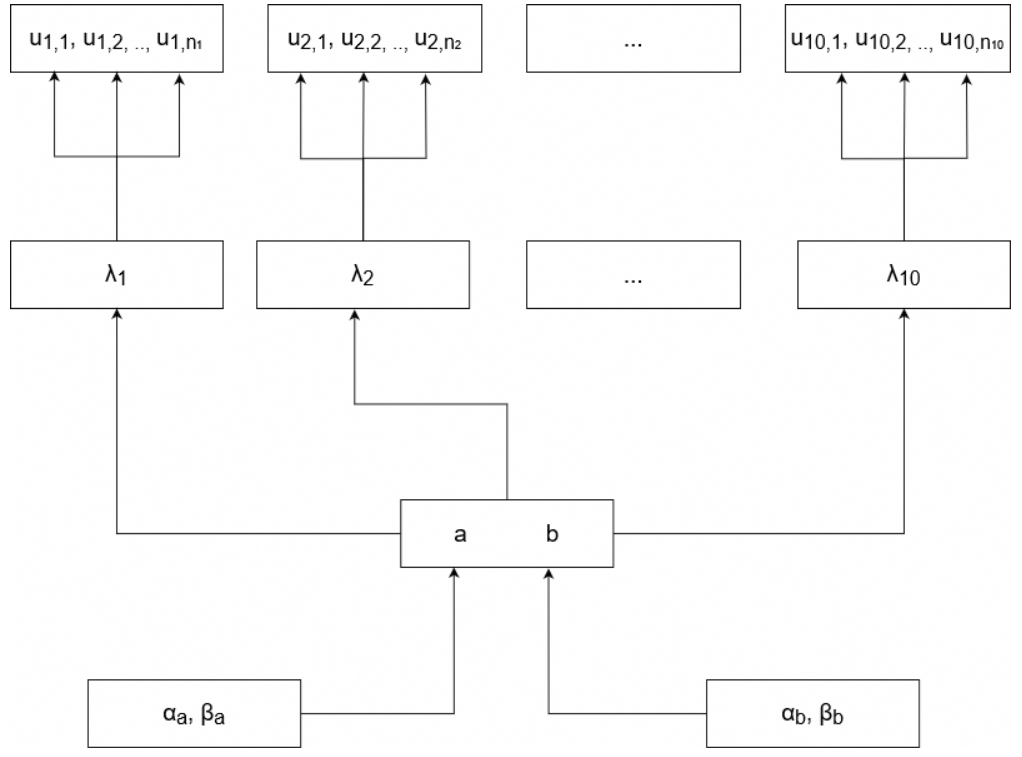

$
\LARGE
u_{i,j}  \sim exp(\lambda_i)\\
\LARGE
\lambda_i  \sim Gamma(a,b) \\
\LARGE
a  \sim  Gamma(\alpha_a, \beta_a)\\
\LARGE
b  \sim  Gamma(\alpha_b, \beta_b)
$

## Posterior calculations

$
\LARGE
\pi(a,b, \lambda_1...\lambda_{10} | u_{ij}) \sim
\\\LARGE L(u_{ij} | a,b, \lambda_1...\lambda_{10}) \pi(a,b, \lambda_1...\lambda_{10}) \sim 
\\\LARGE\prod_{i=1}^{10}L(u_{ij} | \lambda_i) \prod_{i=1}^{10}\pi(\lambda_i|a,b)\pi(a|\alpha_a,\beta_a)\pi(b|\alpha_b,\beta_b)\sim
\\\LARGE\prod_{i=1}^{10}\lambda_i^{n_i}e^{-\lambda_i\sum_{j=1}^{n_i}u_{ij}}\prod_{i=1}^{10}(\frac{\lambda_i^{a-1}e^{-b\lambda_i}b^a}{\Gamma(a)})
\frac{a^{\alpha_a-1}e^{-\beta_aa}\alpha_a^{\beta_a}}{\Gamma(\alpha_a)}\frac{b^{\alpha_b-1}e^{-\beta_bb}\alpha_b^{\beta_b}}{\Gamma(\alpha_b)} \sim
\\\LARGE\prod_{i=1}^{10}\lambda_i^{n_i}e^{-\sum_{i=1}^{10}\lambda_in_i\overline{u}_i}\prod_{i=1}^{10}(\lambda_i^{a-1})\frac{e^{-b\sum_{i=1}^{10}\lambda_i}b^{10a}}{\Gamma(a)^{10}}a^{\alpha_a-1}e^{-\beta_aa}b^{\alpha_b-1}e^{-\beta_bb} \sim
\\\LARGE\frac{a^{\alpha_a-1}}{\Gamma(a)^{10}}b^{\alpha_b-1+10a}\prod_{i=1}^{10}(\lambda_i^{n_i+a-1})e^{-\beta_aa-\beta_bb-\sum_{i=1}^{10}\lambda_i(n_i\overline{u}_i+b)}
$

## Full conditionals

$
\LARGE
\pi(a|.) \sim \frac{\prod_{i=1}^{10}(\lambda_i^{a-1})a^{\alpha_a-1}b^{10a}e^{-\beta_aa}}{\Gamma(a)^{10}}\\\\
$

$
\LARGE
\pi(b|.) \sim b^{\alpha_b+10a-1}e^{-\beta_bb-\sum_{i=1}^{10}\lambda_ib} \sim
\\\LARGE\pi(b|.) \sim b^{\alpha_b+10a-1}e^{-b(\beta_b + \sum_{i=1}^{10}\lambda_i)} \sim
\\\LARGE Gamma(\alpha_b+10a,\beta_b + \sum_{i=1}^{10}\lambda_i)\\\\
$

$
\LARGE
\pi(\lambda_i|.) \sim \lambda_i^{n_i+a-1}e^{-\lambda_i(n_i\overline{u}_i+b)} \sim
\\ \LARGE Gamma(n_i+a,n_i\overline{u}_i+b)
$

## Algoritmic simulation of a sample and estimation of the posterior

### Algoritmic simulation

First we set the actual parameters of the sampling distributions in order to start the simulation:

In [3]:
alpha_a = 1
alpha_b = 1
beta_a = 1
beta_b = 1

We set some random seeds for replicability. The following random seed has been chosen as the best suited for showcasing the rest, but more "purely randomic experiments" have been made. This line can be disabled in order to simulate new parameters each time:

In [4]:
np.random.seed(6544506)

We sample a and b:

In [5]:
a = np.random.gamma(alpha_a, 1/beta_a, size=None)
b = np.random.gamma(alpha_b, 1/beta_b, size=None)

In [6]:
a, b

(0.1907072830624453, 0.5650337155041276)

We used the sampled a and b in order to sample the lambdas:

In [7]:
lambdas = np.random.gamma(a, 1/b, size=10)

In [8]:
print(lambdas)

[4.75147586e-02 9.13523886e-01 2.27085034e-03 1.79177257e-02
 2.68903631e-03 1.48470282e-01 1.03846026e-02 3.88294063e-08
 1.24361469e+00 1.50001005e-01]


Finally, we use the $\lambda_is$ to sample 50 $u_{i,j}$ per single $\lambda_i$ (the resulting samples will not be shown for obvious reasons):

In [9]:
u_samples = np.array([np.random.exponential(1/lambda_i,size=50) for lambda_i in lambdas])

### Estimation of the posterior

As shown above, the full conditionals are the following:

$
\LARGE
\pi(a|.) \sim \frac{\prod_{i=1}^{10}(\lambda_i^{a-1})a^{\alpha_a-1}b^{10a}e^{-\beta_aa}}{\Gamma(a)^{10}}\\\\
\LARGE\pi(b|.) \sim Gamma(\alpha_b+10a,\beta_b + \sum_{i=1}^{10}\lambda_i)\\\\
\LARGE\pi(\lambda_i|.) \sim Gamma(n_i+a,n_i\overline{u}_i+b)
$

"a" unfortunatly does not appear to have a known kernel, hence Metropolis Hastings is required in order to approximate sampling from a. First we code the likelihood of a:

In [10]:
def likelihood_a(lambdas, a, alpha_a, beta_a):  
    return (np.prod(np.power(lambdas, a-1)) * np.power(a,(alpha_a-1))*np.power(b,10*a)*np.exp(-beta_a*a)) / np.power(gamma(a),10)

This is not actually used, since its very numerically unstable, so instead the log likelihood is needed. Instead of taking the log of after gamma(a), we can leverage the "loggama" built-in function, which does the same operation more efficiently in just one step:

In [11]:
def log_likelihood_a(lambdas, a, alpha_a, beta_a):  
   return np.sum((a-1)*np.log(lambdas)) + (alpha_a-1)*np.log(a) + 10*a*np.log(b)-beta_a*a - 10*loggamma(a)
     

Next is the Metropolis Hastings algorithm. A random walk with Uniform(-3,3) has been chosen. "l_type" allows us to switch from a logarithmic rappresentation of the likelihood to a regular likelihood, in case we wanted to use the original function. A slight adjustment has been made to the alghorithm: since "a" cannot be negative, but the random walk can yield negative results, any proposal that is lower than 0 is automatically rejected. This is so that we can still use the simplified rejection function, leveraging a simetrical proposal distribution. The side effect is that we reject far more often, hence we take longer to converge. Two alternative methods would be to use an asymmetric proposal (e.g. partially reflected random walk), accounting for it in the rejection function, or to redo the calculations in order to try and estimate the logarithm of "a", making "a" always positive.

Note: the Burn-in period is not set, so it is left to the calling function to decide what to discard.

Note: having a fixed value ("k") for the Uniform is a very crude version of the alghorithm, since with a small values of "k" and "a">>"k", with an initial guess that is very different from "a", we have troubles ever reaching the actual "a" value. Conversly, with "a"<<"k" we are likely to reject most values or even be completely stuck with the initial guess. The value chosen here works for relatively small "a".

In [12]:
def metropolis_h(likelihood, likelihood_params, param_name, iterations = 500, l_type="log"):
    x = [1]
    for i in range(1, iterations):
        x_next = np.random.uniform(0,x[i-1]+np.random.uniform(-.1,.1))
        #x_next = x[i-1]+np.random.uniform(-.5,.5) if x[i-1]-.5>0 else x[i-1]+np.random.uniform(.1,.5)
        args_next = copy(likelihood_params)
        args_i = copy(likelihood_params)
        args_next[param_name] =x_next
        args_i[param_name] = x[i-1]
        if x_next>0 and np.random.random_sample() < min(1, likelihood(**args_next) - likelihood(**args_i)) if l_type=="log" else  min(1, np.log(likelihood(**args_next)) - np.log(likelihood(**args_i))):
            x.append(x_next)
        else:
            x.append(x[i-1])
    return x

Now we start with chosing the priors. As instructed, we chose uninformative priors by chosing small values of $\alpha$ and $\beta$. We test how uninformative they actually are by sampling from gamma distributions and observing their medians and standard deviations:

In [13]:
alpha_b_prior = alpha_a_prior = .05
beta_b_prior = beta_a_prior = .005
gamma_b = np.random.gamma(alpha_b_prior, 1/beta_b_prior, size=1000)
gamma_a = np.random.gamma(alpha_a_prior, 1/beta_a_prior, size=1000)
print("median gamma a:",np.median(gamma_a),", std gamma a:",np.std(gamma_a))
print("median gamma b:",np.median(gamma_a),", std gamma b:",np.std(gamma_a))

median gamma a: 0.00023063009496412142 , std gamma a: 48.400985004001775
median gamma b: 0.00023063009496412142 , std gamma b: 48.400985004001775


Now we use the Higgs sampler:

Note: it is here that we decide the burn-in period of "a", given the results of the MH alghorithm above. Here we discard the first quarter.

In [ ]:
N = 1000

a_pred = [1]
b_pred = [1]
lambdas_pred = [[1] for _ in range(10)]
next_a = None
for i in tqdm(range(1,N)):
    next_a = metropolis_h(log_likelihood_a, {"lambdas":[lambda_i[i-1] for lambda_i in lambdas_pred],"alpha_a":alpha_a_prior, "beta_a":beta_a_prior}, "a", l_type = "log")
    a_pred.append(np.mean(next_a[int(len(next_a)/4):]))
    b_pred.append(np.random.gamma(alpha_b_prior + 10*a_pred[i], 1/(beta_b_prior + np.sum([lambda_i[i-1] for lambda_i in lambdas_pred])), size=None))
    for j in range(10):
        lambdas_pred[j].append(np.random.gamma(50 + a_pred[i], 1/(np.sum(u_samples[j])+b_pred[i])))

### Results

We can start by calculating the total error percentage:

Note: here we also need to chose a burn-in period and again the first quarter has been chosen.

In [15]:
np.mean([100*abs(a-np.mean(a_pred[int(len(a_pred)/4):]))/a, 100*abs(b - np.mean(b_pred[int(len(b_pred)/4):]))/b,np.mean([100*abs(lambdas[i]-np.mean(lambda_i[int(len(lambda_i)/4):]))/lambdas[i] for i, lambda_i in enumerate(lambdas_pred)])])

18.582224031098487

We can also see the percentages for single parameters (a,b, $\lambda_{1}...\lambda_{10}$):

In [16]:
100*abs(a-np.mean(a_pred[int(len(a_pred)/4):]))/a, 100*abs(b - np.mean(b_pred[int(len(b_pred)/4):]))/b,[100*abs(lambdas[i]-np.mean(lambda_i[int(len(lambda_i)/4):]))/lambdas[i] for i, lambda_i in enumerate(lambdas_pred)]

(0.30376530586481004,
 45.45902957059758,
 [2.986996961142279,
  5.648225366861858,
  6.549863693515076,
  12.39232565544262,
  2.6904024335237016,
  3.5216649174551735,
  52.165279782958706,
  1.6662884232345794,
  0.9494798890959343,
  11.268245045100787])

We can, finally, see direcly the estimated parameters and the real ones(a,b, $\lambda_{1}...\lambda_{10}$):

In [17]:
np.mean(a_pred[int(len(a_pred)/4):]),np.mean(b_pred[int(len(b_pred)/4):]),[np.mean(lambda_i[int(len(lambda_i)/4):]) for lambda_i in lambdas_pred]

(0.1912865856241464,
 0.8218925593189952,
 [0.046095494194968105,
  0.8619259985033701,
  0.0024195879377956094,
  0.020138148567769208,
  0.0027613822116136825,
  0.14324165634171032,
  0.015801759592997008,
  3.947641624305738e-08,
  1.2554225577781177,
  0.1669034861026164])

In [18]:
a, b, lambdas

(0.1907072830624453,
 0.5650337155041276,
 array([4.75147586e-02, 9.13523886e-01, 2.27085034e-03, 1.79177257e-02,
        2.68903631e-03, 1.48470282e-01, 1.03846026e-02, 3.88294063e-08,
        1.24361469e+00, 1.50001005e-01]))

Another way to visualize the results is by plotting the estimated a,b, $\lambda_{1}...\lambda_{10}$ parameters against the real ones and see if the real values fall within the 0.025 and 0.975 quantiles:

In [19]:
def plot_vals_and_quantiles(chain, true_val):
    plt.plot(chain)
    q2_5 = np.quantile(chain, .025)
    q97_5 = np.quantile(chain, .975)
    plt.plot([true_val for _ in range(len(chain))], color="orange", label="real value") 
    plt.plot([q2_5 for _ in range(len(chain))], color="green", label="quantiles") 
    plt.plot([q97_5 for _ in range(len(chain))], color="green") 
    plt.legend() 
    plt.show()

Here we can see "a":

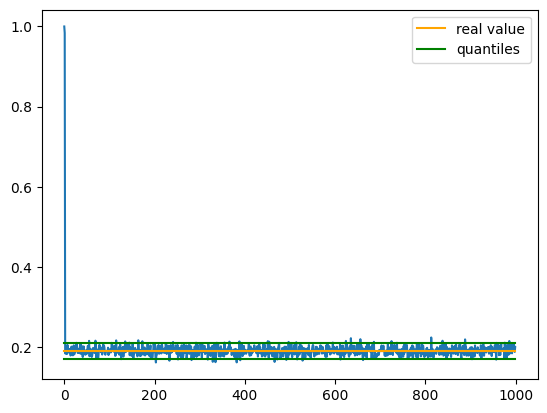

In [20]:
plot_vals_and_quantiles(a_pred, a)

Here we can see "b":

Note: we can see here why a plot might be more useful than the simple error calculation. As we can see, in the series there are many "outliers". Since the parameters have been estimated by taking the mean of the series (after discarding the burn-in period), the outliers had a lot of influence on this mean, drifting the estimation away from the denser regions of the distribution

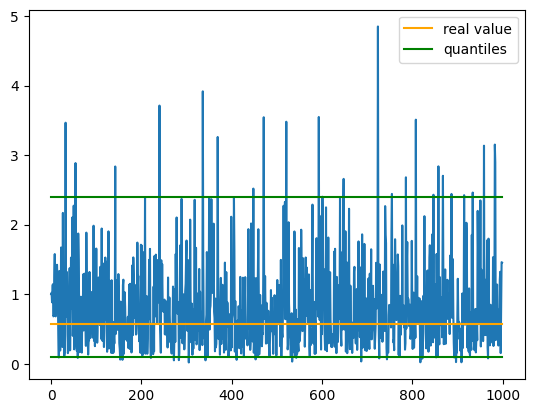

In [22]:
plot_vals_and_quantiles(b_pred, b)

Here we can see the effect described in the "Note" above. We can see the mean of the series, the median of the series and the actual value of b and we can observe how the median is much closer to the original value:

In [26]:
np.mean(b_pred[int(len(b_pred)/4):]), np.median(b_pred[int(len(b_pred)/4):]), b

(0.8218925593189952, 0.6603095994584456, 0.5650337155041276)

Since there are 10 $\lambda_i$, here we can plot the avarage of the 10 real ones and the avarage of the 10 predicted ones for each step of the Gibbs sampler:

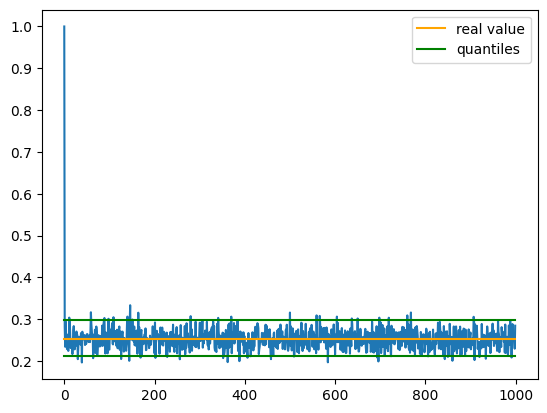

In [23]:
plot_vals_and_quantiles(np.array(lambdas_pred).mean(axis=0), lambdas.mean())